In [ ]:
from pyod.utils.data import generate_data

n_features = 100
n_samples = 200
train_percent = 0.8
use_pca = True

X_train, X_test, y_train, y_test = generate_data(
    n_train=int(n_samples * train_percent),
    n_test=n_samples - int(n_samples * train_percent),
    n_features=n_features,
    contamination=0.1,
    random_state=42
)
# Anomalies should be labeled -1, normal points should be labeled 1
# Now they are 0 (normal) and 1 (anomaly)
y_train[y_train == 1] = -1
y_test[y_test == 1] = -1
y_train[y_train == 0] = 1
y_test[y_test == 0] = 1


In [14]:
# Use StandardScaler to scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

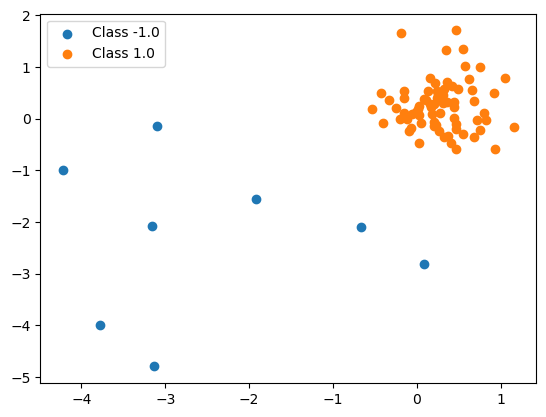

In [15]:
# Plot the data using feature 1 and feature 2
import matplotlib.pyplot as plt
import numpy as np
for c in np.unique(y_train):
    plt.scatter(X_train[y_train==c, 0], X_train[y_train==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


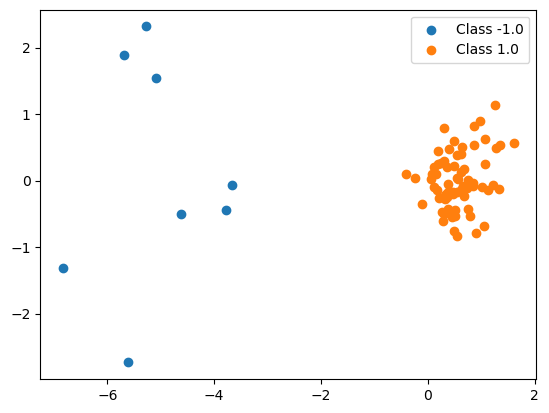

In [16]:
# Plot the data using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
for c in np.unique(y_train):
    plt.scatter(X_pca[y_train==c, 0], X_pca[y_train==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


In [ ]:
if use_pca:
    X_train = X_pca
    X_test = pca.transform(X_test)
    # Print the explained variance ratio
    print("Explained variance:", sum(pca.explained_variance_ratio_))

Explained variance: 0.8759571621270157


In [18]:
# Make benchmark with OneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score
ocsvm = OneClassSVM()
ocsvm.fit(X_train)
# Print training accuracy
y_pred_train = ocsvm.predict(X_train)
print("Training:")
print(classification_report(y_train, y_pred_train))
# Print test accuracy
y_pred = ocsvm.predict(X_test)
print("Test:")
print(classification_report(y_test, y_pred))


Training:
              precision    recall  f1-score   support

        -1.0       0.20      1.00      0.33         8
         1.0       1.00      0.56      0.71        72

    accuracy                           0.60        80
   macro avg       0.60      0.78      0.52        80
weighted avg       0.92      0.60      0.68        80

Test:
              precision    recall  f1-score   support

        -1.0       0.20      1.00      0.33         2
         1.0       1.00      0.56      0.71        18

    accuracy                           0.60        20
   macro avg       0.60      0.78      0.52        20
weighted avg       0.92      0.60      0.68        20



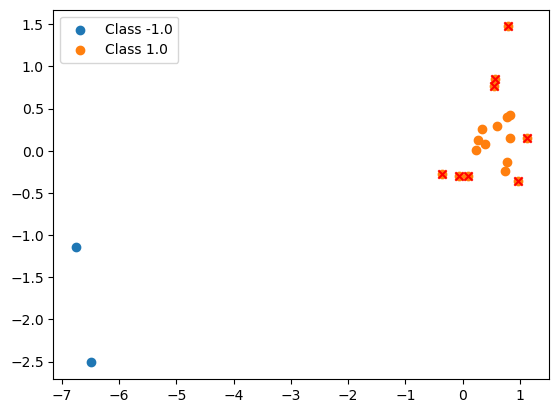

In [19]:
# Visualize the data putting red crosses on data not correctly classified (for test)
for c in np.unique(y_test):
    plt.scatter(X_test[y_test==c, 0], X_test[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test[i, 0], X_test[i, 1], color='red', marker='x')
plt.legend()
plt.show()



In [20]:
n_qubits = X_train.shape[1]
print(f"Number of qubits: {n_qubits}")

Number of qubits: 2


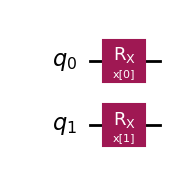

In [21]:
from qiskit.circuit.library import zz_feature_map
# Create the encoding circuit
# Circuit 1
#enc_qc = zz_feature_map(n_qubits,parameter_prefix='x')
# Circuit 2 (angle encoding in Rx)
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
params = ParameterVector('x', n_qubits)
enc_qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    enc_qc.rx(params[i], i)

enc_qc.draw('mpl', fold=-1)

In [22]:
from OCQSVM import OneClassQSVM
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator
# Create the OneClassQSVM instance
shots = 1024
compute_uncompute = ComputeUncompute(sampler=Sampler(mode=AerSimulator(), options={'default_shots': shots}))
kernel = FidelityQuantumKernel(feature_map=enc_qc,
                               fidelity=compute_uncompute)
ocqsvm = OneClassQSVM(quantum_kernel=kernel, verbose=True)
# Fit the model
ocqsvm.fit(X_train)

[LibSVM]

,quantum_kernel,<qiskit_machi...001E991BA5810>
,cache_size,200
,coef0,0.0
,degree,3
,gamma,'scale'
,max_iter,-1
,nu,0.5
,shrinking,True
,tol,0.001
,verbose,True


In [23]:
# Print training accuracy
y_pred_train = ocqsvm.predict(X_train)
print("Training:")
print(classification_report(y_train, y_pred_train))
# Print test accuracy
y_pred = ocqsvm.predict(X_test)
print("Test:")
print(classification_report(y_test, y_pred))

Training:
              precision    recall  f1-score   support

        -1.0       0.20      1.00      0.33         8
         1.0       1.00      0.54      0.70        72

    accuracy                           0.59        80
   macro avg       0.60      0.77      0.51        80
weighted avg       0.92      0.59      0.67        80

Test:
              precision    recall  f1-score   support

        -1.0       0.25      1.00      0.40         2
         1.0       1.00      0.67      0.80        18

    accuracy                           0.70        20
   macro avg       0.62      0.83      0.60        20
weighted avg       0.93      0.70      0.76        20



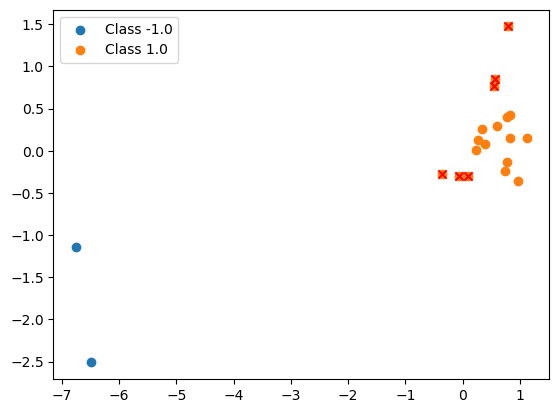

In [24]:
# Visualize the data
import matplotlib.pyplot as plt
for c in np.unique(y_test):
    plt.scatter(X_test[y_test==c, 0], X_test[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test[i, 0], X_test[i, 1], color='red', marker='x')
plt.legend()
plt.show()